In [ ]:
# default_exp inferno_interp

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Interpolation INFERNO loss

Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
Runs and reproduces some of the paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler
from pytorch_inferno.inference import calc_nll, calc_grad_hesse

import numpy as np
from abc import abstractmethod
from typing import Tuple, Optional, List
from fastcore.all import store_attr, partialler

import torch.nn as nn
from torch import Tensor
import torch
from torch.distributions import Distribution

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn.functional as F
from torch import optim, autograd
import torch
from torch.distributions import Normal

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[2.0981e-10, 7.8823e-01, 2.4370e-06, 5.7172e-04, 1.5697e-09, 6.2652e-06,
          6.0719e-02, 5.7233e-04, 6.3415e-05, 1.4984e-01]]),
 tensor([[0.0039, 0.3180, 0.0251, 0.0749, 0.0058, 0.0304, 0.1905, 0.0749, 0.0483,
          0.2282]]),
 tensor([[0.0229, 0.2076, 0.0584, 0.1008, 0.0280, 0.0642, 0.1607, 0.1008, 0.0809,
          0.1759]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

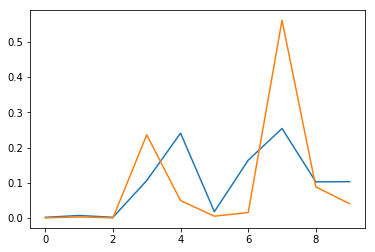

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed.

This process only approximates the effect of shape systematics, since they are evaluated as up/down shape variations and the inter-dependence of them is not accounted for. It is, however, perhaps more realistic/practical, since the exact effect of the nuisances on the input features do not have to be analytically derivable, instead one can use up/down Monte Carlo samples. For this synthetic example, the analytical effects are used.

Running cycle is:
1. for e in #epochs:
    1. for b in #batches:
        1. on_forwards_end:
            1. compute up/down shape variations by augmenting data and passing through model
            1. set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included by running model augmented data to get up/down shapes)
            1. invert hessian and set the diagonal element corresponding to $\mu$ as the loss value

In [ ]:
# export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
    Includes option to randomise params per batch and converge to better values, which results in slightly better performance'''
    def __init__(self, n:int, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1,
                 float_b:bool=False, alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        r'''Compute upd/down shapes. Overide this for specific problem.'''
        pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)/10
        else:              alpha = torch.zeros((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.true_b,
                             f_s=f_s, f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw, alpha_aux=self.alpha_aux, b_aux=self.b_aux)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], b_exp=self.true_b+alpha[1] if self.float_b else self.true_b, alpha=alpha[1+self.float_b:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], b_exp=self.true_b+alpha[1] if self.float_b else self.true_b, alpha=alpha[1+self.float_b:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        f_s = self.to_shape(self.wrapper.y_pred[~b])
        f_b = self.to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
# export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1,
                 float_b:bool=False, alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__(n=n, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr,
                         float_b=float_b, alpha_aux=alpha_aux, b_aux=b_aux)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(10, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100), aug_alpha=False, n_steps=10),
               LossTracker(),SaveBest('weights/best_ii.h5'),EarlyStopping(2)])

1: Train=2076.7199328613283 Valid=1325.6480041503905
2: Train=1074.9161166381837 Valid=975.3848205566406
3: Train=878.14796875 Valid=847.3029248046874
4: Train=733.2050106811523 Valid=721.732392578125
5: Train=655.4998709106445 Valid=645.0333276367187
6: Train=603.2360437011719 Valid=603.6201141357421
7: Train=564.5466311645508 Valid=564.0309881591797
8: Train=523.0719305419922 Valid=533.6254064941406
9: Train=509.93102478027345 Valid=516.5152026367188
10: Train=485.7572409057617 Valid=493.6555554199219
Loading best model with loss 493.6555554199219
CPU times: user 1min 37s, sys: 13.8 s, total: 1min 51s
Wall time: 1min 39s


In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_interp_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,9,1.0
1,0,1.0
2,9,1.0
3,5,1.0
4,8,1.0


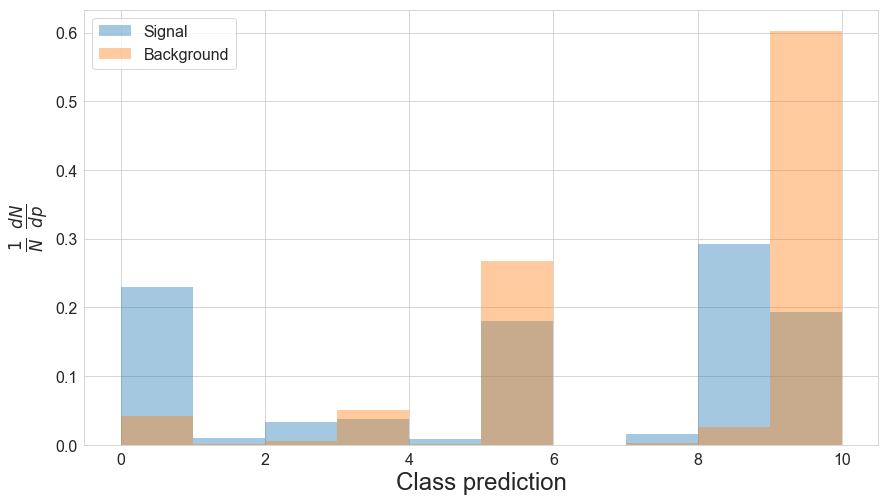

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,9,1.0,9
1,0,1.0,0
2,9,1.0,9
3,5,1.0,5
4,8,1.0,8


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([2.2991e-01, 9.1900e-03, 3.3070e-02, 3.7698e-02, 8.7980e-03, 1.8012e-01,
         2.0000e-13, 1.5654e-02, 2.9161e-01, 1.9395e-01]),
 tensor([4.1444e-02, 1.5740e-03, 4.9960e-03, 5.1054e-02, 1.8340e-03, 2.6711e-01,
         2.0000e-13, 3.1120e-03, 2.6138e-02, 6.0274e-01]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([5.2939e+01, 2.0335e+00, 6.6495e+00, 5.2939e+01, 2.2739e+00, 2.7612e+02,
         2.1000e-10, 3.8947e+00, 4.0719e+01, 6.1243e+02]), tensor(1049.9999))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.45881271, 24.33015251, 24.20706558, 24.08903694, 23.97621155,
       23.86831665, 23.76533318, 23.66730309, 23.57425117, 23.48592377,
       23.40219879, 23.32253838, 23.24811172, 23.17821503, 23.11251831,
       23.05083084, 22.99407005, 22.94145966, 22.89293289, 22.84864044,
       22.80821991, 22.77243042, 22.74008369, 22.71202087, 22.68766022,
       22.66725159, 22.65070534, 22.63777351, 22.62870598, 22.62341881,
       22.62145996, 22.62316513, 22.62859154, 22.63739014, 22.64958763,
       22.6655159 , 22.68467522, 22.70726204, 22.73324203, 22.76234436,
       22.79460526, 22.8299427 , 22.86899757, 22.91102791, 22.95614815,
       23.00424194, 23.05524254, 23.10955048, 23.16658211, 23.22685623,
       23.28968048, 23.35592079, 23.42487526, 23.4964695 , 23.57086563,
       23.64832687, 23.72815704, 23.81087685, 23.89663887, 23.98479462,
       24.07526207])

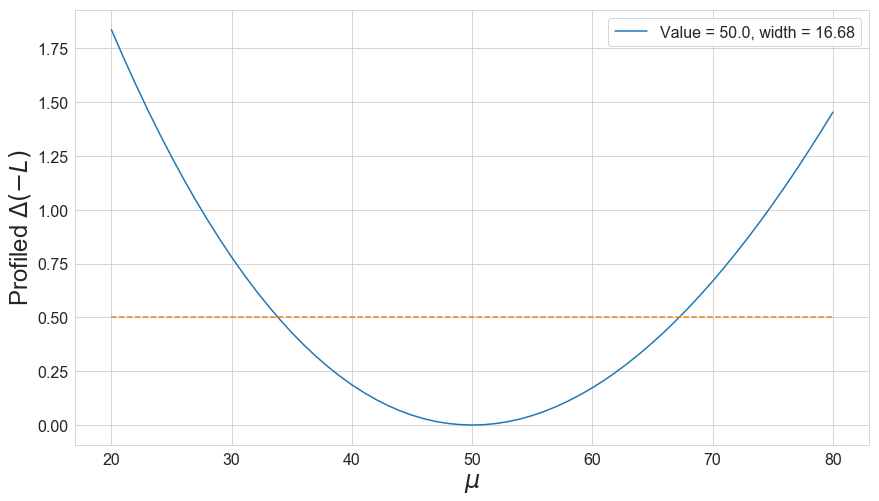

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,9,1.0,9,9,9,9,9,9,9,9,9,9,9
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,9,1.0,9,9,9,9,9,9,9,9,9,9,9
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,8,1.0,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999997,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999998,5,0.0,5,5,5,5,5,5,5,5,5,5,5


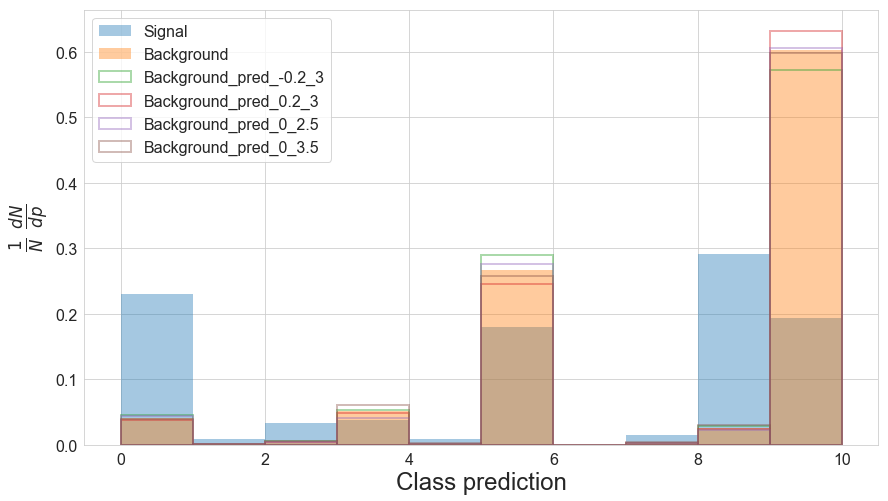

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([4.8094e-02, 1.7440e-03, 4.7020e-03, 4.2210e-02, 1.3180e-03, 2.9840e-01,
        2.0000e-13, 2.3160e-03, 2.4980e-02, 5.7624e-01])
tensor([4.4822e-02, 1.6700e-03, 5.2240e-03, 5.2560e-02, 1.8520e-03, 2.8920e-01,
        2.0000e-13, 3.2560e-03, 2.8832e-02, 5.7259e-01])
tensor([4.2014e-02, 1.5800e-03, 5.7080e-03, 6.1708e-02, 2.3560e-03, 2.8044e-01,
        2.0000e-13, 4.3920e-03, 3.3106e-02, 5.6870e-01])
tensor([4.4716e-02, 1.6480e-03, 4.4740e-03, 4.0704e-02, 1.3000e-03, 2.7632e-01,
        2.0000e-13, 2.1720e-03, 2.2286e-02, 6.0638e-01])
tensor([4.1444e-02, 1.5740e-03, 4.9960e-03, 5.1054e-02, 1.8340e-03, 2.6711e-01,
        2.0000e-13, 3.1120e-03, 2.6138e-02, 6.0274e-01])
tensor([3.8636e-02, 1.4840e-03, 5.4800e-03, 6.0202e-02, 2.3380e-03, 2.5836e-01,
        2.0000e-13, 4.2480e-03, 3.0412e-02, 5.9884e-01])
tensor([4.1644e-02, 1.5920e-03, 3.9960e-03, 3.8880e-02, 1.3180e-03, 2.5483e-01,
        2.0000e-13, 2.0300e-03, 1.9690e-02, 6.3602e-01])
tensor([3.8372e-02, 1.5180e-03, 4.5180e-0

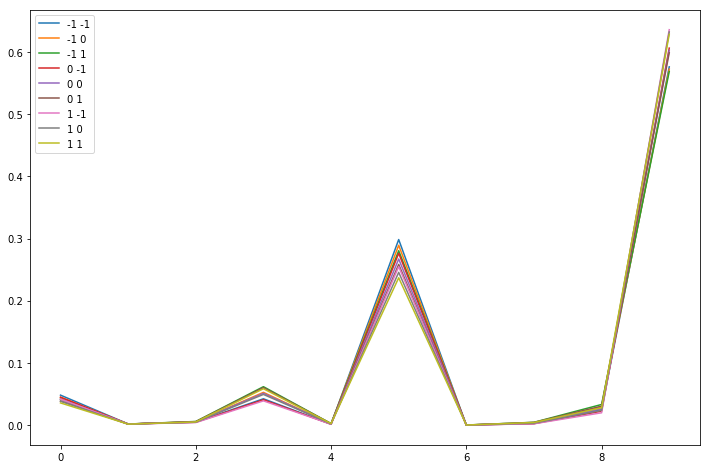

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

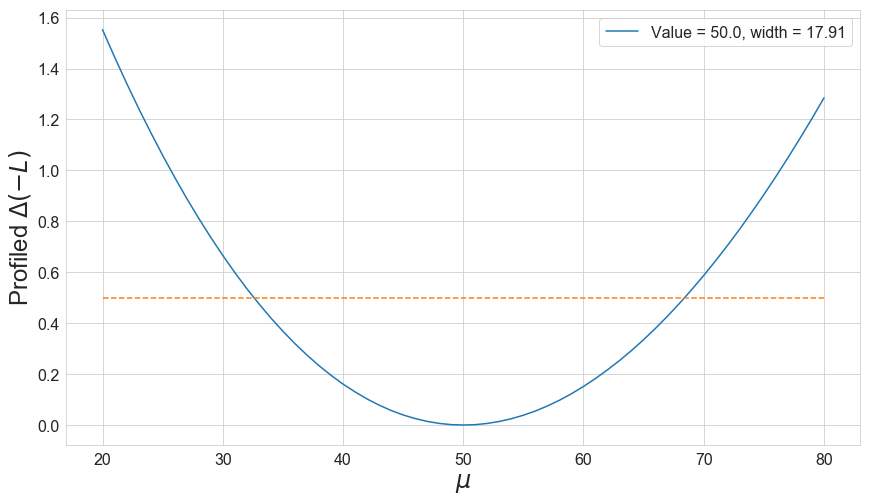

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

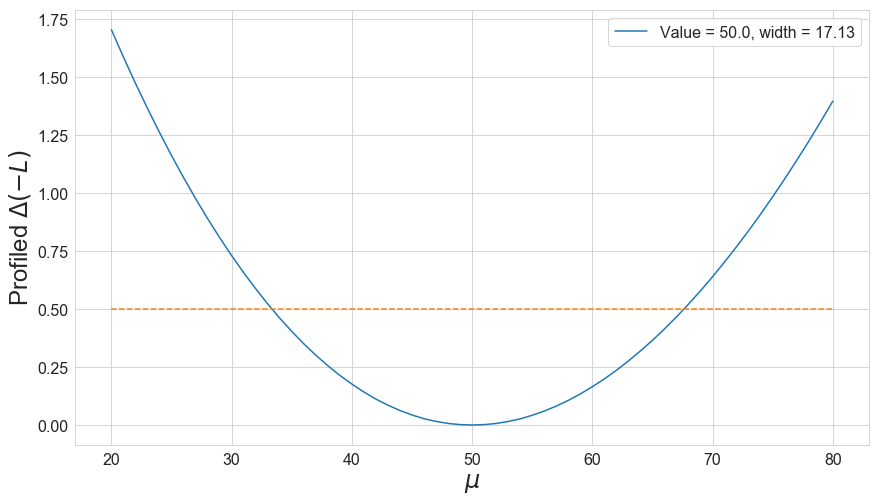

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

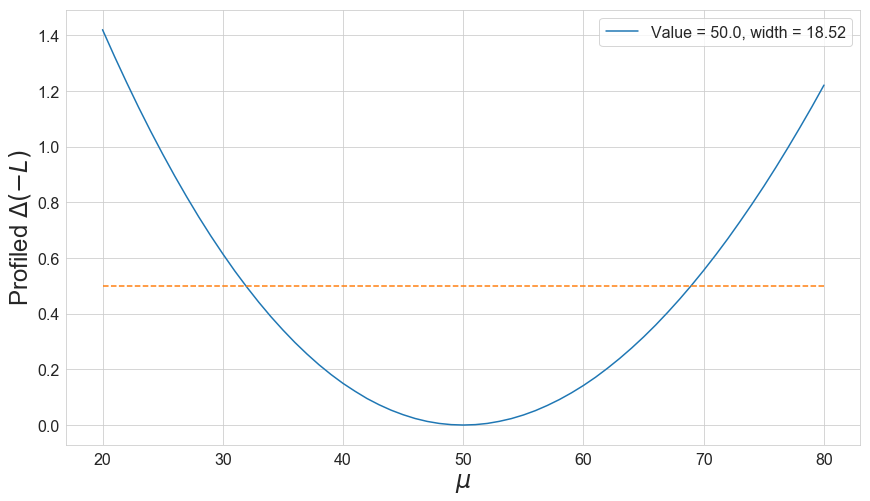

In [ ]:
plot_likelihood(nll-nll.min())

## BM 3

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [ ]:
nll = to_np(nll)

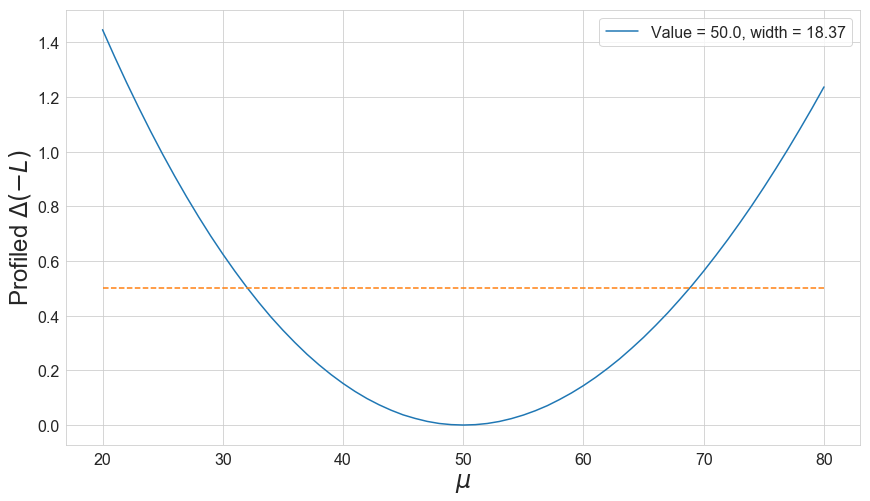

In [ ]:
plot_likelihood(nll-nll.min())

## BM 4

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3672,  0.2749, 25.8559])
Linear regime: Mu 21.0, alpha tensor([-0.3540,  0.2641, 24.9345])
Linear regime: Mu 22.0, alpha tensor([-0.3409,  0.2534, 24.0175])
Linear regime: Mu 23.0, alpha tensor([-0.3278,  0.2429, 23.1049])
Linear regime: Mu 24.0, alpha tensor([-0.3149,  0.2325, 22.1967])
Linear regime: Mu 25.0, alpha tensor([-0.3019,  0.2222, 21.2928])
Linear regime: Mu 26.0, alpha tensor([-0.2891,  0.2120, 20.3932])
Linear regime: Mu 27.0, alpha tensor([-0.2763,  0.2020, 19.4979])
Linear regime: Mu 28.0, alpha tensor([-0.2636,  0.1920, 18.6068])
Linear regime: Mu 29.0, alpha tensor([-0.2509,  0.1822, 17.7199])
Linear regime: Mu 30.0, alpha tensor([-0.2384,  0.1725, 16.8372])
Linear regime: Mu 31.0, alpha tensor([-0.2258,  0.1629, 15.9586])
Linear regime: Mu 32.0, alpha tensor([-0.2134,  0.1534, 15.0840])
Linear regime: Mu 33.0, alpha tensor([-0.2010,  0.1440, 14.2136])
Linear regime: Mu 34.0, alpha tensor([-0.1887,  0.1348, 13.3471])
Linear reg

In [ ]:
nll = to_np(nll)

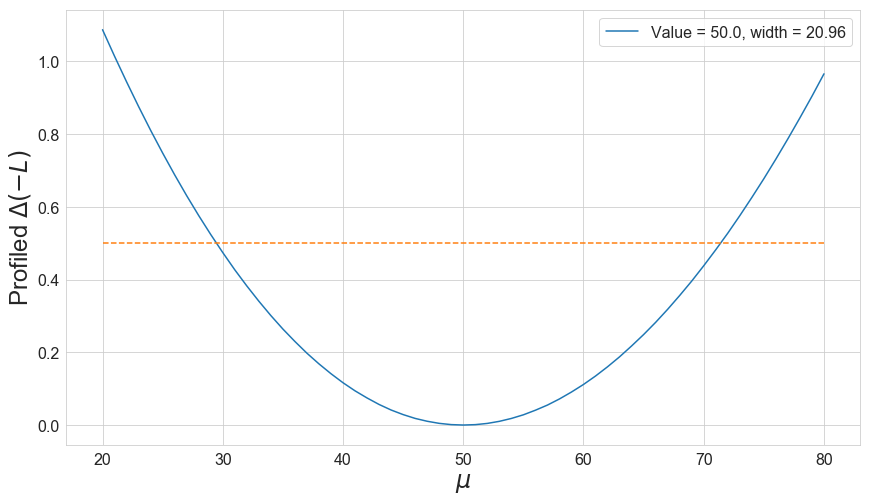

In [ ]:
plot_likelihood(nll-nll.min())